# The Heat Diffusion Model:

The Equation:

$\frac{\partial T(x,t)}{\partial t} = \alpha \frac{\partial^2 T (x,t)}{\partial x^2}$

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [2]:
class HeatDiffusion(object):
    
    def __init__(self, alpha: float, L: float, delta_x: float, delta_t: float, T:int, temp_l:float, temp_r: float, init_distr_func):
        """
        Initializes the Heat Diffusion model with input Parameters.

            Parameters:
                    alpha (float)         : Scaling factor
                    L (float)             : Space Interval for x
                    delta_x(float)        : Space discretization step
                    delta_t(float)        : Time discretization step
                    T(int)                : Amount of time steps for t
                    temp_r(float)         : Boundary conditions right
                    temp_l(float)         : Boundary conditions left
                    init_distr_func(func)  : Initial heat distribution function
            Returns:
                    Initialized Heat Diffusion Model class.
        """
        self.temp = None
        self.alpha = alpha
        self.L = L                      
        self.delta_x = delta_x          
        self.delta_t = delta_t          
        self.T = T                      
        self.temp_r = temp_r
        self.temp_l = temp_l
        self.init_distr_func = init_distr_func 
        self.x = np.arange(0,L,delta_x)  # vector of x values
        self.t = np.arange(0,T,delta_t)  # vector of time values
        # Initial heat distribution
        temp_0 = np.empty(len(self.x))
        for i in range(len(self.x)):
            temp_0[i] = self.init_distr_func(self.x[i])

        self.temp_0 = temp_0   # Final vector of the initial heat distribution

################################################################################################

    def forward_time_centered_space(self):
        """
        Finds the Forward Solution to the above defined Partial Differential Equation.

            Returns:
                    An array of the Temperature in time and space
        """
        # The true stability condition is not yet derived (for simplicity)
        if self.alpha > 0.5:
            print("No stable solution")

        else:
            temp = np.zeros([len(self.x), len(self.t)+1])
            temp[:,0] = self.temp_0

            for t in range(1, len(self.t)+1):
                temp[0,t] = temp[0,t-1] + ((self.alpha * self.delta_t/ self.delta_x) * (temp[1,t-1]- 2*temp[0,t-1]+ self.temp_r))
                temp[len(self.x)-1,t] = temp[len(self.x)-1,t-1] + ((self.alpha * self.delta_t/ self.delta_x) * (self.temp_l- 2*temp[len(self.x)-1,t-1]+ temp[len(self.x)-1,t-1]))

                for x in range(1, len(self.x)-1):
                    temp[x,t] = temp[x,t-1] + ((self.alpha * self.delta_t/ self.delta_x) * (temp[x+1,t-1]- 2*temp[x,t-1]+ temp[x-1,t-1]))

            self.temp = temp
            return temp
    
    def backward_time_central_space(self):
        """
        Finds the Backward Solution to the above defined Partial Differential Equation.

        Returns:
                An array of the Temperature in time and space
        """
        # Initialize the Temp Matrix
        temp = np.zeros([len(self.x), len(self.t)+1])
        # Set the initial values:
        temp[:,0] = self.temp_0
        # Boundary Conditions
        temp[0,0] = self.temp_r
        temp[len(self.x)-1,0] = self.temp_l
        # Initialize the A Matrix:
        a = np.zeros([len(self.x),len(self.x)])
        # Fill the A matrix with the elements
        # Define the Elements
        f = (self.alpha*self.delta_t)/ self.delta_x**2
        
        for elem in range(len(self.x)):

            # Boundary Conditions:
            if elem == 0:
                a[0,0] = 1
                   
            elif elem == (len(self.x) - 1):
                a[len(self.x)-1,len(self.x)-1] = 1
                    
            else:
                a[elem,elem]     = (1+2*f)
                a[elem,elem-1]   = -f
                a[elem, elem +1] = -f

        for time in range(1,len(self.t)):
            temp[:, time] = np.matmul(np.linalg.inv(a),temp[:, time-1])
            # Boundary Conditions:
            temp[0, time-1] = self.temp_r
            temp[len(self.x)-1, time-1] = self.temp_l

        self.temp = temp
        return temp
                
    def crank_nicolson(self):
        """
        Uses the Crank Nicolson Scheme to find the Solution to the above defined Partial Differential Equation.

        Returns:
                An array of the Temperature in time and space
        """
        # Initialize the Temp Matrix
        temp = np.zeros([len(self.x), len(self.t)+1])
        # Set the initial values:
        temp[:,0] = self.temp_0
        # Boundary Conditions
        temp[0,0] = self.temp_r
        temp[len(self.x)-1,0] = self.temp_l
        # Initialize the A and B Matrices:
        a = np.zeros([len(self.x),len(self.x)])
        b = np.zeros([len(self.x),len(self.x)])

        # Define the F element
        f = self.alpha*self.delta_t/self.delta_x**2
        
        # Fill the matrices
        for elem in range(len(self.x)):

            if elem == 0:
                a[elem,elem] = 1
                b[elem,elem] = 1
            elif elem == len(self.x) -1:
                a[elem,elem] = 1
                b[elem,elem] = 1
            else:
                a[elem,elem] = 1 + f
                a[elem, elem-1] = -1/2*f
                a[elem, elem+1] = -1/2*f

                b[elem,elem] = 1 - f
                b[elem,elem-1] = 1/2 * f
                b[elem,elem+1] = 1/2 * f
        
        # Create the final matrix  
        a_b = np.matmul(np.linalg.inv(a),b)
        
        for time in range(1,len(self.t)):
            temp[:, time] = np.matmul(a_b,temp[:, time-1])
            # Boundary Conditions:
            temp[0, time-1] = self.temp_r
            temp[len(self.x)-1, time-1] = self.temp_l

        self.temp = temp
        return temp
    
    #def analytical_solution(self):
    #    temp = np.zeros([len(self.x), len(self.t)+1])
    #    for elem in range(len(self.x)-1):
    #        
    #        for time in range(len(self.t)):
    #                temp[elem,time] = np.exp(-(np.pi**2)*self.t[time])*np.sin(np.pi*self.x[elem])+0.1*np.exp(-(np.pi**2)*(10**2)*self.t[time])*np.sin(100*np.pi*self.x[elem])
    #                
    #    return temp 

#############################################################################################

    def surface_plot(self, temp):

        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

        # The Data
        
        x = np.delete(self.x,1)
        x = x[:-1]
        
        time, space = np.meshgrid(self.t, x)

        temp = np.delete(temp,0,0)
        temp = np.delete(temp,len(self.x)-2,0)
        temp = temp[:,:-1]
        
        # Plot the surface.
        surf = ax.plot_surface(time, space, temp, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

        ax.set_xlabel("Time")
        ax.set_zlabel("Temperature")
        ax.set_ylabel("x")
        
        ax.view_init(20,120)
        # Add a color bar which maps values to the colors.
        #fig.colorbar(surf, aspect=5)

        plt.show()



        Initializes the Heat Diffusion model with input Parameters.

            Parameters:
                    alpha (float)         : Scaling factor
                    L (float)             : Space Interval for x
                    delta_x(float)        : Space discretization step
                    delta_t(float)        : Time discretization step
                    T(int)                : Amount of time steps for t
                    temp_r(float)         : Boundary conditions right
                    temp_l(float)         : Boundary conditions left
                    init_distr_func(func)  : Initial heat distribution function
            Returns:
                    Initialized Heat Diffusion Model class.
        

        Uses the Crank Nicolson Scheme to find the Solution to the above defined Partial Differential Equation.

        Returns:
                An array of the Temperature in time and space
        


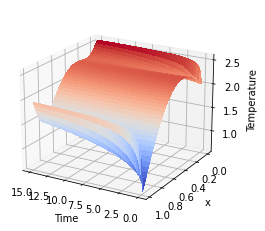

In [3]:
model = HeatDiffusion(alpha= 0.0004, L= 1, delta_x= 0.01, delta_t= 0.05, T=15 , temp_l = 2, temp_r=2.60, init_distr_func= lambda x: 2 - (1.5*x) + np.sin(np.pi * x))
print(model.__init__.__doc__)

#temp = model.backward_time_central_space()
#print(model.backward_time_central_space.__doc__)
#model.surface_plot(temp = temp)

temp_2 = model.crank_nicolson()
print(model.crank_nicolson.__doc__)
model.surface_plot(temp = temp_2)

#temp_3 = model.analytical_solution()
#model.surface_plot(temp_3)